v1.0

The objective of this notebook is to:
- calculate and plot the **learning curve**

# Pre-checks

In [1]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [2]:
import time
t_start = time.time()

In [3]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.1
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)


Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
#!pip install icecream
#!pip install watermark
#!pip install fastparquet

## Import Modules

In [5]:
# Base libraries
import os
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=0.8)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Global Parameters

In [6]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "07.01"

## Global Helper Functions

In [7]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


In [8]:
def fast_run_sampling(df, sample_fraction):
    """Return a fraction of the dataset."""
    print("Labels before sampling:\n", df['label'].value_counts())
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed) 
    #df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
    print("Labels after sampling:\n", df['label'].value_counts())
    return df
    

In [9]:
def calculate_duration(t_start, t_end):
    """Return run time in minutes."""
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# 3.0 Load Data

In [10]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"
PATH_DATA_FIG = "reports/figures/"
PATH_DATA_HTML = "reports/html/"

# Dictionary to store file names and their corresponding dataframes
files = {
    "train_features_clean_stats.parquet.gzip": "df_wiki_train_stats",
    "test_features_clean_stats.parquet.gzip": "df_wiki_test_stats",
    "train_features_rs.parquet.gzip": "df_wiki_train_rs",
    "test_features_rs.parquet.gzip": "df_wiki_test_rs",
    "train_features_nltk.parquet.gzip": "df_wiki_train_nltk",
    "test_features_nltk.parquet.gzip": "df_wiki_test_nltk",
    "train_features_aoa.parquet.gzip": "df_wiki_train_aoa",
    "test_features_aoa.parquet.gzip": "df_wiki_test_aoa",
    "train_features_crb.parquet.gzip": "df_wiki_train_crb",
    "test_features_crb.parquet.gzip": "df_wiki_test_crb",
    "train_features_w2v.parquet.gzip": "df_wiki_train_w2v",
    "test_features_w2v.parquet.gzip": "df_wiki_test_w2v",
   # "train_mNB_predict.parquet.gzip": "df_wiki_train_MNB",  # data leakage risk
   # "test_mNB_predict.parquet.gzip": "df_wiki_test_MNB",    # data leakage risk
}

# Load data into corresponding dataframes
for file, df_name in files.items():
    if df_name not in globals():
        globals()[df_name] = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)


Not a Google Drive Environment. Loading local files.


In [11]:
# Combine dataframes into one
df_train = pd.DataFrame()
df_train = pd.concat([df_train, df_wiki_train_stats], axis=1)
df_train = pd.concat([df_train, df_wiki_train_rs], axis=1)
df_train = pd.concat([df_train, df_wiki_train_nltk], axis=1)
df_train = pd.concat([df_train, df_wiki_train_aoa], axis=1)
df_train = pd.concat([df_train, df_wiki_train_crb], axis=1)
df_train = pd.concat([df_train, df_wiki_train_w2v], axis=1)

if FASTRUN:
    df_train = fast_run_sampling(df_train, sample_fraction)


In [12]:
df_train.shape

(416768, 155)

In [13]:
df_rfecv_selected_feature = pd.read_csv(ROOT_PATH+PATH_DATA_INT+"RFECV10-RF-selected_features-table_04.02.csv")
rfecv_selected_feature = sorted(df_rfecv_selected_feature['Selected Features'].to_list())
ic(len(rfecv_selected_feature));


ic| len(rfecv_selected_feature): 125


# Calculate Learning Curve

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


In [15]:
# load dataset
def load_dataset(df, n_samples, rfecv_selected_feature):
    ic(n_samples);
    n_samples = int(n_samples/2)
    df_split = df.groupby('label').sample(n=n_samples, random_state=seed) 

    X_columns = df_split.columns.to_list()
    X_columns = list(set(X_columns) -
                        {"label", "original_text", "cleaned_text", "stats_language_code"})

    X = df_split[rfecv_selected_feature].copy()
    y = df_split["label"]

    ic(X.shape);
    ic(y.shape);

    return X, y

In [16]:
# evaluate a model
def evaluate_model(X, y, k):
    start_time_eval = time.time()
    # define model evaluation procedure
    skfold = StratifiedKFold(n_splits=k)
    scaler = MinMaxScaler((0, 1))
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # define pipeline
    pipeline = Pipeline([('scaler', scaler), ('estimator', rf)])
    
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=skfold, n_jobs=-1)
    
    end_time_eval = time.time()
    calculate_duration(start_time_eval, end_time_eval)

    # return summary stats
    return [scores.mean(), scores.std()]
 

In [17]:
# define number of samples to consider
start_size = int(len(df_train))/10
max_size =  int(len(df_train))
sizes = np.arange(start_size, max_size, start_size)
sizes = [int(round(no/1000) * 1000) for no in sizes]

ic(sizes);


ic| sizes: [42000, 83000, 125000, 167000, 208000, 250000, 292000, 333000, 375000]


In [18]:
# evaluate each number of samples
means = list()
stds = list()
err = list()
k = 10

for n_samples in sizes:
    gc.collect()
    # get a dataset
    X, y = load_dataset(df_train, n_samples, rfecv_selected_feature)
    # evaluate a model on this dataset size
    mean, std = evaluate_model(X, y, k)
    # store
    means.append(mean)
    stds.append(std)
    # summarize performance
    print('>%d: %.3f (%.3f)' % (n_samples, mean, std))

# define error bar as 2 standard deviations from the mean or 95%
err = [min(1, s * 2) for s in stds]

69

ic| n_samples: 42000
ic| X.shape: (42000, 125)
ic| y.shape: (42000,)


0.56 minutes
>42000: 0.672 (0.008)


227

ic| n_samples: 83000
ic| X.shape: (83000, 125)
ic| y.shape: (83000,)


1.09 minutes
>83000: 0.680 (0.004)


227

ic| n_samples: 125000
ic| X.shape: (125000, 125)
ic| y.shape: (125000,)


1.72 minutes
>125000: 0.689 (0.003)


227

ic| n_samples: 167000
ic| X.shape: (167000, 125)
ic| y.shape: (167000,)


2.38 minutes
>167000: 0.696 (0.003)


227

ic| n_samples: 208000
ic| X.shape: (208000, 125)
ic| y.shape: (208000,)


3.09 minutes
>208000: 0.701 (0.003)


227

ic| n_samples: 250000
ic| X.shape: (250000, 125)
ic| y.shape: (250000,)


3.78 minutes
>250000: 0.705 (0.002)


227

ic| n_samples: 292000
ic| X.shape: (292000, 125)
ic| y.shape: (292000,)


4.54 minutes
>292000: 0.710 (0.001)


227

ic| n_samples: 333000
ic| X.shape: (333000, 125)
ic| y.shape: (333000,)


5.31 minutes
>333000: 0.713 (0.002)


227

ic| n_samples: 375000
ic| X.shape: (375000, 125)
ic| y.shape: (375000,)


6.15 minutes
>375000: 0.716 (0.002)


In [19]:
df_results = pd.DataFrame(
    {
    'Training Samples': sizes,
    'Training Samples (log)': np.log(sizes),
    'Accuracy Score': means, 
    'STD': std,
    'Err': err,
    }
)

df_results

,Training Samples,Training Samples (log),Accuracy Score,STD,Err
0,42000,10.645425,0.672000,0.001561,0.015020
1,83000,11.326596,0.680253,0.001561,0.007953
2,125000,11.736069,0.688976,0.001561,0.005301
3,167000,12.025749,0.696347,0.001561,0.005061
4,208000,12.245293,0.701072,0.001561,0.005845
5,250000,12.429216,0.704900,0.001561,0.003171
6,292000,12.584509,0.709894,0.001561,0.002271
7,333000,12.715898,0.713162,0.001561,0.004475
8,375000,12.834681,0.716016,0.001561,0.003121


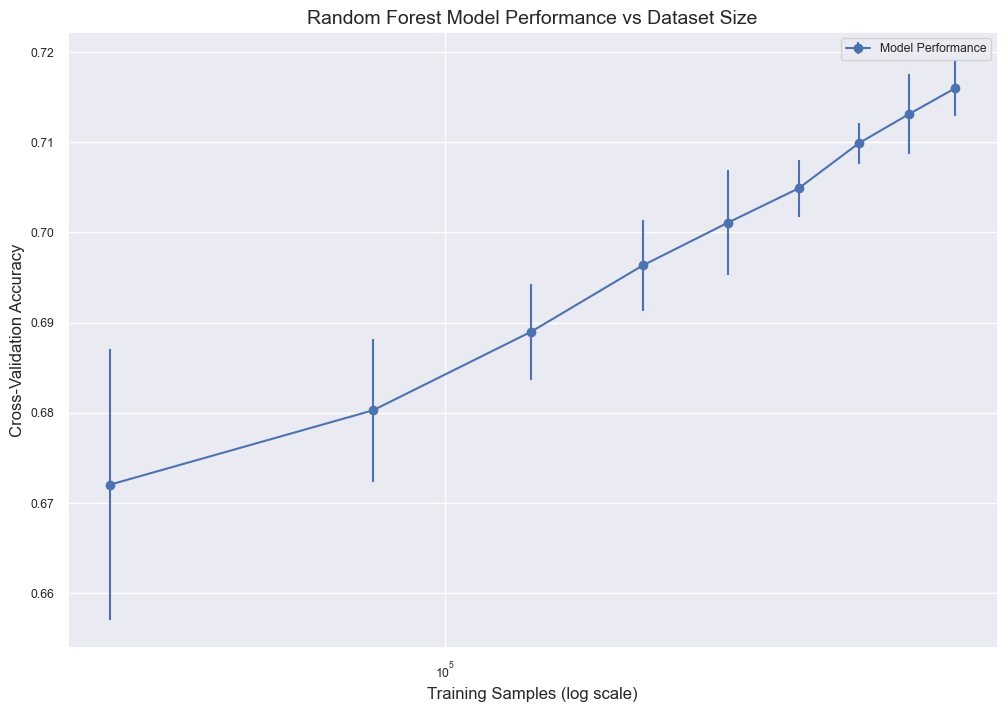

In [20]:
# plot dataset size vs mean performance with error bars
plt.errorbar(sizes, means, yerr=err, fmt='-o', label='Model Performance')
#plt.rcParams["figure.figsize"] = (4,4)

# change the scale of the x-axis to log
ax = plt.gca()
ax.set_xscale("log", nonpositive='clip')

# add labels and titles to the plot
plt.title('Random Forest Model Performance vs Dataset Size', fontsize=11)
plt.xlabel('Training Samples (log scale)', fontsize=10)
plt.ylabel('Cross-Validation Accuracy', fontsize=10)
plt.legend()

# show the plot
plt.show();

In [21]:
t_end = time.time()
calculate_duration(t_start, t_end);


28.88 minutes


# Export

In [22]:
today = date.today()
# Save the figure
if not FASTRUN:
    plt.savefig(ROOT_PATH+PATH_DATA_FIG+f'{today}_Learning_curve_CV{k}_chart_07.01.png');

<Figure size 1200x800 with 0 Axes>

In [23]:
if not FASTRUN:
    df_results.to_csv(ROOT_PATH+PATH_DATA_REP+f'{today}_Learning_curve_CV{k}_table_07.01.csv', index=False)
 

# Watermark

In [24]:
%watermark

Last updated: 2023-02-24T23:32:51.098328+01:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.8.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [25]:
%watermark --iversions

numpy     : 1.24.1
seaborn   : 0.12.2
matplotlib: 3.6.3
pandas    : 1.5.3



-----


In [26]:
output_file = f'{ROOT_PATH}{PATH_DATA_HTML}{today}_07.01_model_evaluation_learning_curve.html'
!jupyter nbconvert --to html "07.01_model_evaluation_learning_curve.ipynb" --output {output_file}

[NbConvertApp] Converting notebook 07.01_model_evaluation_learning_curve_GC.ipynb to html
[NbConvertApp] Writing 632804 bytes to ..\reports\html\2023-02-24_07.01_model_evaluation_learning_curve_GC.html
